In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import copy
from torch.autograd import Variable
import torch.nn.functional as F
import time
from attention import clones, future_mask, MultiHeadedAttention, FeedForwardNetwork, Embeddings, PositionalEncoding, Generator, LayerNorm, SublayerConnection, Encoder, Decoder, EncoderDecoder, make_model, Batch

In [2]:
vocab_size = 10
batch_size = 16
nbatches = 20
d_model = 512

In [3]:
class zrange:
    def __init__(self,batch_size, n_batches, vocab_size, seq_len):
        self.data = torch.from_numpy(np.random.randint(1, vocab_size, size=(batch_size*nbatches, seq_len)))
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.seq_len = seq_len

    def __iter__(self):
        return zrange_iter(self.n_batches, self.batch_size, self.data, self.seq_len)

class zrange_iter:
    def __init__(self, n_batches, batch_size, data, seq_len):
        self.i = 0
        self.n_batches = n_batches
        self.batch_size = batch_size
        self.data = data
        self.seq_len = seq_len

    def __iter__(self):
        # Iterators are iterables too.
        # Adding this functions to make them so.
        return self

    def __next__(self):
        if self.i < self.n_batches:
            idx = self.i*self.batch_size
            src = Variable(self.data[idx:idx+batch_size,:], requires_grad=False)
            tgt = Variable(self.data[idx:idx+batch_size,:], requires_grad=False)
            self.i += 1
            return Batch(src, tgt, 0)
        else:
            raise StopIteration()

In [4]:
z = zrange(batch_size, nbatches, vocab_size, 10)

In [5]:
list(z)

In [6]:
data = torch.from_numpy(np.random.randint(1, vocab_size, size=(1,batch_size*nbatches, d_model)))
data[:, 0] = 1

In [7]:
## testing make_model
# model = make_model(vocab_size, vocab_size)


In [8]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [9]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        #print("out shape: ", out.size())
        #print("tgt_y shape: ", batch.trg_y.size())
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens.item()
        tokens += batch.ntokens.item()
        if i % 1 == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    #print("total_loss: ", total_loss)
    #print("total_tokens: ", total_tokens)
    #return total_loss / total_tokens

In [10]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        # x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm


In [11]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1).long(), self.confidence)
        true_dist[:, self.padding_idx] = 0 # we don't penalize the start symbol
        mask = torch.nonzero(target.data == self.padding_idx) # masking out where the target is the padded index
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


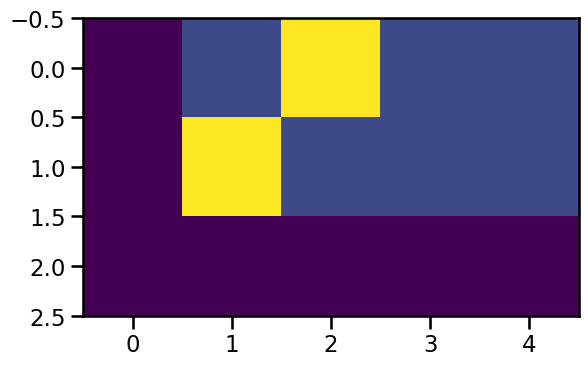

In [12]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

In [13]:
vocab_size = 10
criterion = LabelSmoothing(size=vocab_size, padding_idx=0, smoothing=0.0)
#criterion = nn.CrossEntropyLoss()
model = make_model(vocab_size, vocab_size, N=2)
#data_generator = data_gen(data,vocab_size,batch_size,nbatches,d_model)
data_generator = zrange(batch_size, nbatches, vocab_size,20)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))


for epoch in range(0):
    print("epoch: ", epoch)
    model.train()
    run_epoch(data_generator, model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_generator, model, 
                    SimpleLossCompute(model.generator, criterion, None)))


d_model:  512
h:  8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def greedy_decode(model, source, source_mask, max_decode_len, start_symbol):
    encoder_outputs = model.encode(source, source_mask) # todo(annhe): check source_masking
    print("encoder outputs shape: ", encoder_outputs.size())
    ys = torch.ones(1,1).fill_(start_symbol).type_as(source.data) # create a 1x1 array with element '<sos>'
    for i in range(max_decode_len-1):
        #print("i: ", i)
        #print("ys shape: ", ys.size())
        output_mask = torch.Tensor(future_mask(ys.size(1)).type_as(src.data))
        output = model.greedy_decode(encoder_outputs, source_mask, torch.Tensor(ys),
                              output_mask,pos=i)
        # output is size N x L x D
        # we need to pass it through the generator
        prob = model.generator(output[:,-1,:])
        _, vocab_symbol = torch.max(prob, dim=1)
        vocab_symbol = vocab_symbol.detach().unsqueeze(0)
        ys = torch.cat([ys, vocab_symbol], dim=1)
    return ys
model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7]]) )
src_mask = Variable(torch.ones(1, 1, 7) )
#result = greedy_decode(model, src, src_mask, max_decode_len=7, start_symbol=1)
#print(result.detach())

In [15]:
class Candidate:
    tokens: torch.Tensor # N x L 
    scores: torch.Tensor # N x L 
    
    def __init__(self, tokens=None, scores=None):
        self.tokens=tokens
        self.scores=scores
        

In [16]:
def beam_decode(model, source, source_mask, max_decode_len, start_symbol, k=3):
    encoder_outputs = model.encode(source, source_mask) # todo(annhe): check source_masking
    print("encoder outputs shape: ", encoder_outputs.size())
    ys = torch.ones(1,1).fill_(start_symbol).type_as(source.data)
    scores = torch.ones(1,1).type(torch.float64) # is this correct?
    decode_list = []
    decode_list.append(Candidate(ys,scores))
    for i in range(max_decode_len-1):
        new_decode_list = []
        print("iteration: ", i)
        for j, candidate in enumerate(decode_list):
            print("j: ", j)
            print("candidate shape: ", candidate.tokens.size())
        print("*"*15)
        for j, candidate in enumerate(decode_list):
            print("candidate j: ", j)
            ys = candidate.tokens
            logits = candidate.scores
            output_mask = torch.Tensor(future_mask(ys.size(1)).type_as(src.data))
            print("encoder_outputs shape: ", encoder_outputs.size())
            print("ys shape: ", ys.size())
            print("output mask shape: ", output_mask.size())
            output = model.greedy_decode(encoder_outputs, source_mask, torch.Tensor(ys),
                              output_mask,pos=i)
            # output is size N x L x D
            # we need to pass it through the generator
            prob = model.generator(output[:,-1,:])
            logits, vocab_symbols = torch.topk(prob, k, dim=1)
            vocab_symbols = vocab_symbols.detach()
            logits = logits.detach()
            print("vocab_symbols size: ", vocab_symbols.size())
            chunks = torch.chunk(vocab_symbols, k, dim=1)
            logit_chunks = torch.chunk(logits, k, dim=1)
            for chunk, logit_chunk in zip(chunks, logit_chunks):
                cur = torch.cat([ys, chunk], dim=1)
                cur_logits = torch.cat([logits, logit_chunk], dim=1)
                # print("chunking ys shape: ", ys.size()) # expected N x L
                new_decode_list.append(Candidate(cur,cur_logits))
        decode_list = new_decode_list
        print("length of decode list: ", len(decode_list))
        sorted_list = sorted(decode_list, key = lambda x:torch.sum(x.scores,axis=1)) # N = 1 for this to make sense
        print("-"*15)
        ### get the top k
        return sorted_list[:k]
            
model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7]]) )
src_mask = Variable(torch.ones(1, 1, 7) )
result = beam_decode(model, src, src_mask, max_decode_len=7, start_symbol=1)
print(result)    

query shape:  torch.Size([1, 7, 64])
key transpose shape:  torch.Size([1, 64, 7])
value shape:  torch.Size([1, 7, 64])
attention_weights shape:  torch.Size([1, 7, 7])
mask shape:  torch.Size([1, 1, 7])
query shape:  torch.Size([1, 7, 64])
key transpose shape:  torch.Size([1, 64, 7])
value shape:  torch.Size([1, 7, 64])
attention_weights shape:  torch.Size([1, 7, 7])
mask shape:  torch.Size([1, 1, 7])
query shape:  torch.Size([1, 7, 64])
key transpose shape:  torch.Size([1, 64, 7])
value shape:  torch.Size([1, 7, 64])
attention_weights shape:  torch.Size([1, 7, 7])
mask shape:  torch.Size([1, 1, 7])
query shape:  torch.Size([1, 7, 64])
key transpose shape:  torch.Size([1, 64, 7])
value shape:  torch.Size([1, 7, 64])
attention_weights shape:  torch.Size([1, 7, 7])
mask shape:  torch.Size([1, 1, 7])
query shape:  torch.Size([1, 7, 64])
key transpose shape:  torch.Size([1, 64, 7])
value shape:  torch.Size([1, 7, 64])
attention_weights shape:  torch.Size([1, 7, 7])
mask shape:  torch.Size([

AttributeError: 'list' object has no attribute 'detach'